# TP2 Mean Shift

Read, understand, and complete and run the following notebook. You must return the completed notebook, including your answers and illustrations (you may need to add cells to write your code or comments). 

Return your work by e-mail using a single file (ipynb or zip) with the format 'introvis18_tp2_yourname.ipynb'


## 0. Imports

In [1]:
import numpy as np 
# this is the key library for manipulating arrays. Use the online ressources! http://www.numpy.org/

import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
# used to read images, display and plot http://matplotlib.org/api/pyplot_api.html . 
#You can also check this simple intro to using ipython notebook with images https://matplotlib.org/users/image_tutorial.html

#%matplotlib inline 
# to display directly in the notebook

import scipy.ndimage as ndimage
# one of several python libraries for image procession

plt.rcParams['image.cmap'] = 'gray' 
# by default, the grayscale images are displayed with the jet colormap: use grayscale instead

from skimage.color import rgb2luv,luv2rgb
# for colorspace conversions

import random as rd

from drawnow import drawnow



## 1. Mean shift

In this section, we will implement Mean Shift and test is on simple synthetic data (i.e. points you will sample from a probability distribution with known density - see below).

1: Generate a random vector of 100 2D points 'data1' with 50 points sampled from a Gaussian distribution of variance 1 centered in (0,0) and 50 points sampled from a Gaussian distribution of variance 1 centered in (2,1). Plot your points using the 'plt.scatter' function. This 'data' vector will be the synthetic data you will try to cluster, and for which the algorithm should manage to separate the point coming from each of the two Gaussians. Repeat to create a vector 'data2' with the center of the second Gaussian in (3,3). Which will be the easiest data vector to cluster? Test both in the following experiments.

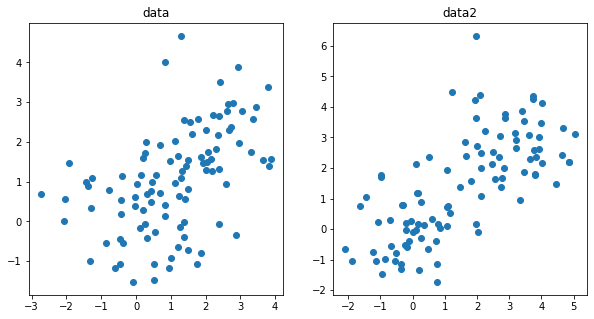

In [2]:
def compute_vector(mean1, var1, mean2, var2, nb_points):
    
    N = nb_points//2
    
    data1 = np.random.multivariate_normal(2*[mean1], np.diag(2*[var1]), N)
    data2 = np.random.multivariate_normal(2*[mean2], np.diag(2*[var2]), N)
    
    return np.concatenate((data1, data2))


data = compute_vector(0, 1, 2, 1, 100)
data2 = compute_vector(0, 1, 3, 1, 100) # plus facile à clusteriser car les 2 nuages de points sont plus espacés

fig = plt.figure(figsize = (10,5))
    
ax = fig.add_subplot(1, 2, 1)
ax.set_title("data")
ax.scatter(*data.T)
    
ax = fig.add_subplot(1, 2, 2)
ax.set_title("data2")
ax.scatter(*data2.T)

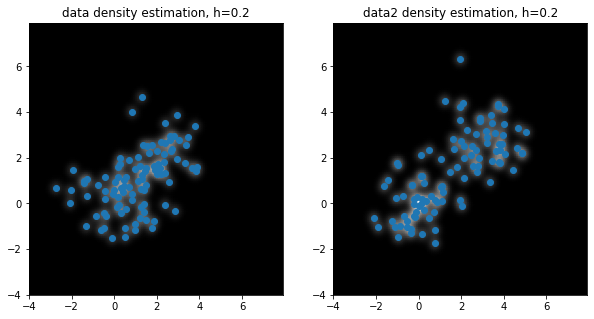

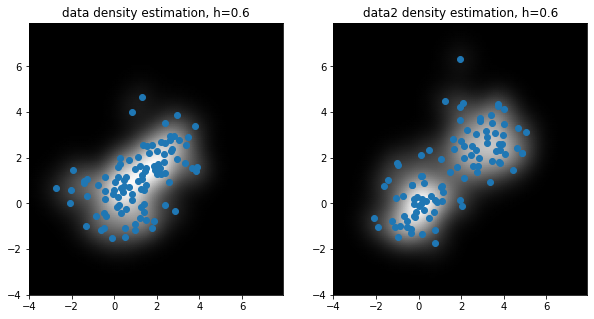

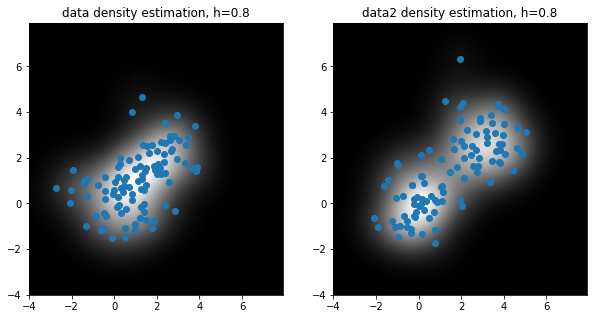

In [3]:
def norm2(x):
    return np.sum(x**2)

def k_n(r):
    return np.exp(-0.5*r)

def k_e(r):
    return 1-r if 0<=r<=1 else 0


def kernel_density_estimator(x, y, data, h, k=k_n):
    n = len(data)
    sum = 0
    for i in range(n):
        sum += k( ((x-data[i][0])**2 + (y-data[i][1])**2)/(h**2) )
    return sum/(len(data) * h)

x = np.arange(-4,8,0.1)    
X,Y = np.meshgrid(x,x)

Test = [0.2, 0.6, 0.8]
for t in Test:
    
    fig = plt.figure(figsize = (10,5))
    
    ax = fig.add_subplot(1, 2, 1)
    ax.set_title("data density estimation, h="+str(t))
    ax.pcolormesh(X, Y, kernel_density_estimator(X,Y, data, t, k_n), shading="gouraud")
    ax.scatter(*data.T)

    
    ax = fig.add_subplot(1, 2, 2)
    ax.set_title("data2 density estimation, h="+str(t))
    ax.pcolormesh(X, Y, kernel_density_estimator(X,Y, data2, t), shading="gouraud")
    ax.scatter(*data2.T)

plt.show()

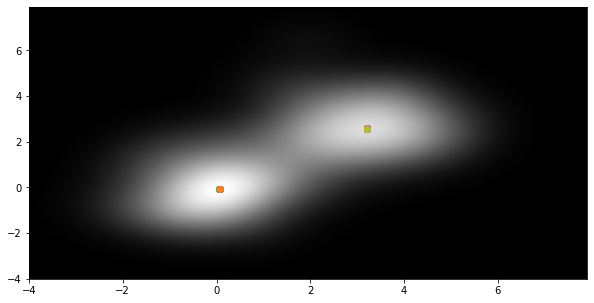

In [4]:
def m(elem, data, h, dist=norm2, kernel=k_n):
    n = len(data)
    sum1 = 0
    sum2 = 0
    for i in range(n):
        ker = -kernel( dist((elem-data[i])/h) )
        sum1 += data[i]* ker
        sum2 += ker
        
    return sum1/(sum2 + 1e-16)


def mean_shift_algo(elem, data, h, eps = 0.00001, kernel=k_n, dist=norm2 ):
    
    elem2 = m(elem, data, h, dist, k_n)
    while(dist(elem2-elem)>eps):
        elem = elem2
        elem2 = m(elem, data, h, dist, k_n)
        
    return elem2



H = 0.8

x = np.arange(-4,8,0.1)    
X,Y = np.meshgrid(x,x)
plt.figure(figsize=(10,5))
plt.pcolormesh(X, Y, kernel_density_estimator(X, Y, data2, H, k_n ), shading="gouraud")

for i in range(99):
    converge = mean_shift_algo(data2[i], data2, H, kernel=k_n)
    plt.scatter(*converge)

plt.show()

# 2. Segmentation

In [5]:
def Ksr(x, hs, hr, k=k_n, dist=norm2):
    xs = x[0:2]
    xr = x[2:]
    return k(dist(xs/hs))*k(dist(xr/hr))
    

def Img_to_data(Img):
    Out = []
    for i in range(Img.shape[0]):
        for j in range(Img.shape[1]):
            Out.append([i,j,*Img[i][j]])
    return np.array(Out)

def Img_to_data2(Img):
    out = np.zeros((Img.shape[0], Img.shape[1], 5))
    for i in range(Img.shape[0]):
        for j in range(Img.shape[1]):
            out[i,j] =np.array([i,j,*Img[i][j]])
    return out


def msr(elem, data, hs, hr, dist=norm2, kernel=k_n):
    n = len(data)
    sum1 = 0
    sum2 = 0
    for i in range(n):
        ker = -Ksr(elem,hs,hr,kernel,dist)
        sum1 += data[i]* ker
        sum2 += ker
        
    return sum1/(sum2 + 1e-16)

def ms_filtering(Img, hs, hr, dist=norm2, k=k_n, eps_s=2, eps_r=0.00001):
    data = Img_to_data(Img)
    z = np.zeros(data.shape)
    
    for i in range(len(data)):
        print('step: '+str(i+1)+'/'+str(len(data))+'\r', sep=' ', end='', flush=True)
        elem = data[i]
        elem2 = msr(elem, data, hs, hr, dist, k)
        
        while(dist(elem[0:2]-elem2[0:2])>eps_s or dist(elem[2:]-elem2[2:])>eps_r):
            elem = elem2
            elem2 = msr(elem, data, hs, hr, dist, k)
            print(elem2)
                        
        z[i] = np.concatenate((data[i][0:2], elem2[2:]))
        print(z[i])
        
    return z

In [6]:
def ms_filtering2(Img, hs, hr, num_iters):
    hr2 = hr**2
    height, width = Img.shape[0], Img.shape[1] 
    for i in range(height):
        for j in range(width):
            actual_i, actual_j = i, j
            i_old, j_Old = 0, 0
            L_old, U_old, V_old = 0, 0, 0
            L, U, V = Img[i, j][2:]
            # initial value of mean shift
            ms_shift = 5; 
            iters = 0
            while iters  < num_iters and ms_shift > 1:
                mi, mj = 0, 0
                mL, mU, mV = 0, 0, 0
                nb_neighbours = 0

                j_min= max(0, j - hs)
                j_max = min(width, j + hs + 1);
                i_min = max(0, i - hs)
                i_max = min(height, i + hs + 1);

                # spatial neighborhood
                for k in range(i_min, i_max):     
                    for l in range(j_min, j_max):
                        L2 = Img[k, l][2] 
                        U2 = Img[k, l][3] 
                        V2 = Img[k, l][4] 
                        
                        dL = L2 - L
                        dU = U2 - U
                        dV = V2 - V

                        # color neighborhood
                        if dL * dL + dU * dU + dV * dV <= hr2 :
                            mi += k
                            mj += l
                            mL += L2
                            mU += U2
                            mV += V2
                            nb_neighbours += 1
                i_old, j_old = actual_i, actual_j
                L_old, U_old, V_old = L, U, V
                 
                # uniform kernel
                L = mL /  nb_neighbours
                U = mU /  nb_neighbours
                V = mV /  nb_neighbours
                actual_i = (mi /  nb_neighbours + 0.5)
                actual_j = (mj /  nb_neighbours + 0.5)
                di = actual_i - i_old
                dj = actual_j - j_old
                dL = L - L_old
                dU = U - U_old
                dV = V - V_old

                # mean shift vector
                ms_shift = di * di + dj * dj + dL * dL + dU * dU + dV * dV
                iters += 1
            
            # set L, U and V values
            Img[i, j][2] = L
            Img[i, j][3] = U
            Img[i, j][4] = V
    
    return Img

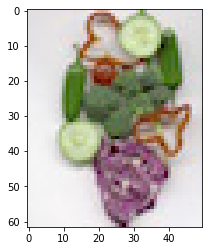

In [7]:
name='legumes_small.jpg'

I = plt.imread(name)
plt.imshow(I)

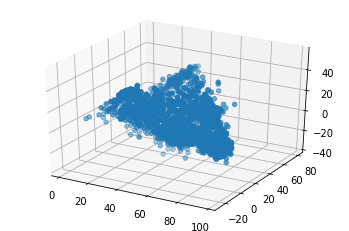

In [8]:
I_luv = rgb2luv(I)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*I_luv.T)

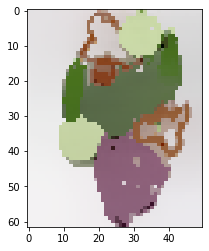

In [9]:
I_5channels = Img_to_data2(I_luv)
I_5channels_filtered = ms_filtering2(I_5channels, 8, 16, 100)

def data_to_Img2(z):
    return z[:,:,2:]

I_new2 = data_to_Img2(I_5channels_filtered)

plt.figure()
plt.imshow(luv2rgb(I_new2))

In [ ]:
z = ms_filtering(I_luv, 5, 20)

In [ ]:
def data_to_Img(z):
    w,h = z[-1][0:2]
    I_out = np.zeros((int(w)+1,int(h)+1,3))
    for d in z:
        I_out[int(d[0])][int(d[1])] = d[2:]
    return I_out

I_new = data_to_Img(z)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*I_luv.T) 
ax.scatter(*I_new.T)

In [ ]:
plt.figure()
plt.imshow(luv2rgb(I_new))

In [ ]:
def ms_segmentation(z, hs, hr, dist=norm2):
    Out = []
    clusters = [z[0]]
    for i in range(len(z)):
        for j in range(len(clusters)):
            if not(dist(z[i][0:2]-clusters[j][0:2])<hs and  dist(z[i][2:]-clusters[j][2:])<hr):
                clusters.append[z[i]]